## Training a Neural Network

We will be training a neural network using a modified version of the VAE network. By elmininating the KL divergence term on the loss function and setting epsilon equal to zero, we arrive at an autoencoder network that reconstructs hand-written digits. 

In [22]:
import pickle, gzip
import matplotlib.pyplot as plt 
import numpy as np
import sys
%matplotlib inline

In [23]:
sys.path.append('..')
from vae import vae

In [24]:
with gzip.open('data\mnist.pkl.gz', 'rb') as f:
    train, test, val = pickle.load(f, encoding='latin1')
    mnist = train[0]

After we import the VAE class, we set up the parameters and intialize the weights. The loss function is the squared error and the activation function is the sigmoid. As part of backpropogation, we also need to pass in the derviative of the loss and activation. 

$$Loss(y, \hat{y}) = \sum (y - \hat{y})^2$$
$$\sigma(x) = \frac{1}{1 + exp(-x)}$$

In [25]:
params = {
    'alpha' : 0.1,
    'max_iter' : 2,
    'activation' : (lambda x: 1 / (1 + np.exp(-x))),
    'grad_act' : (lambda x: np.exp(-x) / (1 + np.exp(-x))**2),
    'loss' : (lambda y, yhat: 0.5 * np.sum((y - yhat)**2)),
    'grad_loss' : (lambda y, yhat: y - yhat)
}

example = vae([784, 200], [784, 200], params)

### Training on Digits

Here we pass a training digit, a zero, of size 28 by 28 pixels.

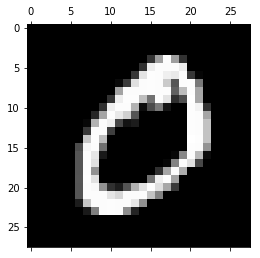

In [26]:
in_digit = np.array((mnist[1][None,:]))
plt.matshow(in_digit.reshape((28,28)), cmap='gray')
pass

We intialize the weights to be random, so the first pass looks jumbled.

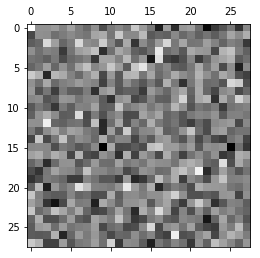

In [27]:
out_digit = example.feedforward(in_digit)
plt.matshow(out_digit.reshape((28,28)), cmap = 'gray')
pass

We then train the network to reduce the loss function and reproduce the training image. Here are the reconstructed images after just the first 10 training interations. It very rapidly reassembles the digit without error.

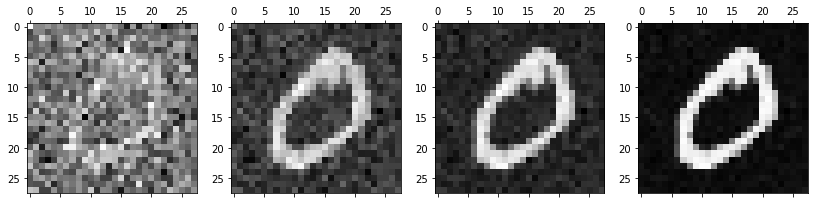

In [28]:
fig, ax = plt.subplots(1,4, figsize = (14, 10))

example.train(in_digit)
pred1 = example.predict(in_digit)
ax[0].matshow(pred1.reshape((28,28)), cmap='gray')

example.train(in_digit)
pred2 = example.predict(in_digit)
ax[1].matshow(pred2.reshape((28,28)), cmap='gray')

example.train(in_digit)
pred3 = example.predict(in_digit)
ax[2].matshow(pred3.reshape((28,28)), cmap='gray')

example.train(in_digit)
pred4 = example.predict(in_digit)
ax[3].matshow(pred4.reshape((28,28)), cmap='gray')
pass

### References

1. [MNIST data](http://deeplearning.net/tutorial/gettingstarted.html)